# Optical Molasses: Diffusion-Out Time + Diffusion Constant (from CCD widths)

This notebook shows two complementary analyses:

1. **Diffusion-out time** from a *photodiode fluorescence trace* (signal falls to background).
2. **Diffusion constant** from *CCD cloud widths* using the diffusion law:
\[
w^2(t) = w_0^2 + 2Dt
\]
(per axis).

> Note: In true diffusion, the slope of \(w^2\) vs \(t\) must be **positive**. If it is negative, you're not in a purely diffusive regime (still cooling/compressing, timing offset, etc.).


In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Part A — Diffusion-out time from photodiode trace

We define an operational **diffusion-out time** \(t_\text{out}\) as the first time when the smoothed signal becomes indistinguishable from background:

\[
V(t) \le V_{\rm bg} + k\,\sigma_{\rm bg}
\]

where \(V_{\rm bg}\) and \(\sigma_{\rm bg}\) are estimated from a late-time window.


In [4]:
def load_molasses_txt(path):
    """
    Robust loader for lab photodiode molasses files.
    Automatically detects where numeric data starts.
    """

    with open(path, "r") as f:
        lines = f.read().splitlines()

    # --- Parse sampling info from second line ---
    # Expected something like: "10000.0   5000   500.0"
    header_numbers = None
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 3:
            try:
                fs = float(parts[0])
                n = int(float(parts[1]))
                header_numbers = (fs, n)
                break
            except:
                continue

    if header_numbers is None:
        raise ValueError("Could not find sampling frequency in header.")

    fs, n = header_numbers

    # --- Find where numeric voltage data begins ---
    data_start = None
    for i, line in enumerate(lines):
        try:
            float(line.strip())
            data_start = i
            break
        except:
            continue

    if data_start is None:
        raise ValueError("No numeric data found in file.")

    v = []
    for line in lines[data_start:]:
        try:
            v.append(float(line.strip()))
        except:
            break

    v = np.array(v)
    t = np.arange(len(v)) / fs

    return t, v, fs


def moving_average_reflect(x, win):
    """Centered moving average with reflect padding."""
    win = int(win)
    if win <= 1:
        return x.copy()
    if win % 2 == 0:
        win += 1
    pad = win // 2
    xr = np.pad(x, pad, mode="reflect")
    k = np.ones(win) / win
    return np.convolve(xr, k, mode="valid")


def estimate_t_out(t, v, *, tail_ms=50, smooth_ms=5, k_sigma=2.0):
    """Estimate diffusion-out time from a photodiode trace.

    Parameters
    ----------
    tail_ms : late-time window used to estimate background mean/std
    smooth_ms : moving-average smoothing window
    k_sigma : threshold in units of background standard deviation

    Returns
    -------
    t_out : float or None
        First time where smoothed v falls below Vbg + k_sigma*sigma_bg.
    Vbg, sigma_bg : background stats from late-time window
    v_smooth : smoothed voltage trace
    """
    dt = t[1] - t[0]
    fs = 1.0 / dt

    tail = int(round(tail_ms * 1e-3 * fs))
    tail = max(tail, 10)

    Vbg = float(np.mean(v[-tail:]))
    sigma_bg = float(np.std(v[-tail:]))

    win = int(round(smooth_ms * 1e-3 * fs))
    win = max(win, 1)

    v_smooth = moving_average_reflect(v, win)

    thresh = Vbg + k_sigma * sigma_bg
    idx = np.where(v_smooth <= thresh)[0]
    t_out = float(t[idx[0]]) if len(idx) else None
    return t_out, Vbg, sigma_bg, v_smooth


def plot_photodiode_out_time(t, v, t_out, Vbg, sigma_bg, v_smooth, k_sigma=2.0, title=""):
    thresh = Vbg + k_sigma * sigma_bg

    plt.figure(figsize=(8, 4))
    plt.plot(t, v, label="raw")
    plt.plot(t, v_smooth, label="smoothed")
    plt.axhline(Vbg, linestyle="--", label="Vbg")
    plt.axhline(thresh, linestyle=":", label=f"Vbg + {k_sigma}σ")
    if t_out is not None:
        plt.axvline(t_out, linestyle="--", label=f"t_out = {t_out*1e3:.1f} ms")
    plt.xlabel("time [s]")
    plt.ylabel("photodiode voltage [V]")
    plt.title(title)
    plt.legend()
    plt.tight_layout()


molasses1.txt: fs=10000 Hz, t_out = 85.1 ms, Vbg=0.1205 V, σbg=0.0007 V
molasses2.txt: fs=10000 Hz, t_out = 88.3 ms, Vbg=0.1212 V, σbg=0.0006 V
molasses3.txt: fs=10000 Hz, t_out = 141.7 ms, Vbg=0.1327 V, σbg=0.0009 V
molaasses4.txt: fs=10000 Hz, t_out = 111.4 ms, Vbg=0.1236 V, σbg=0.0008 V


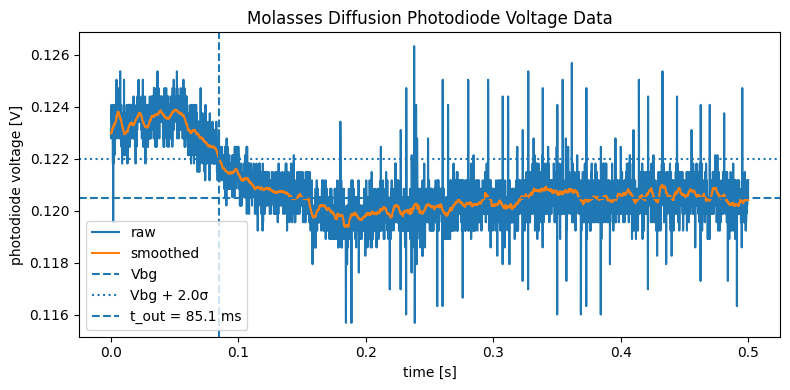

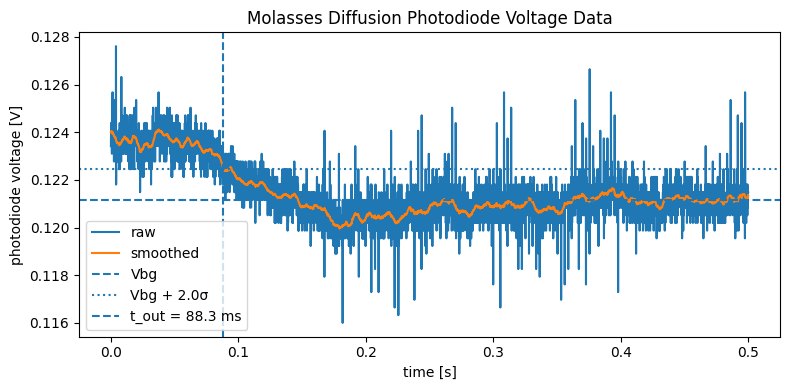

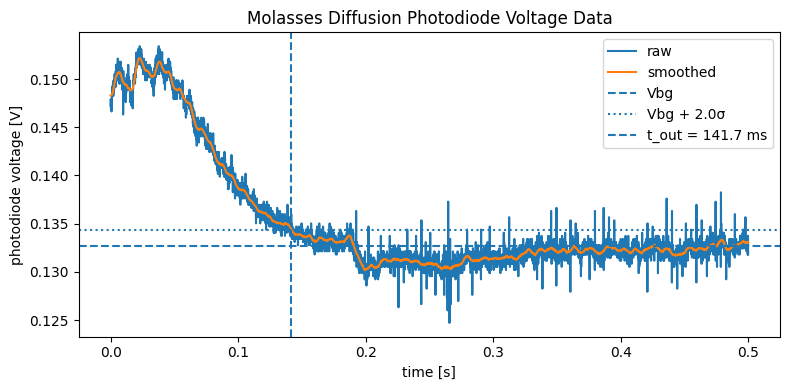

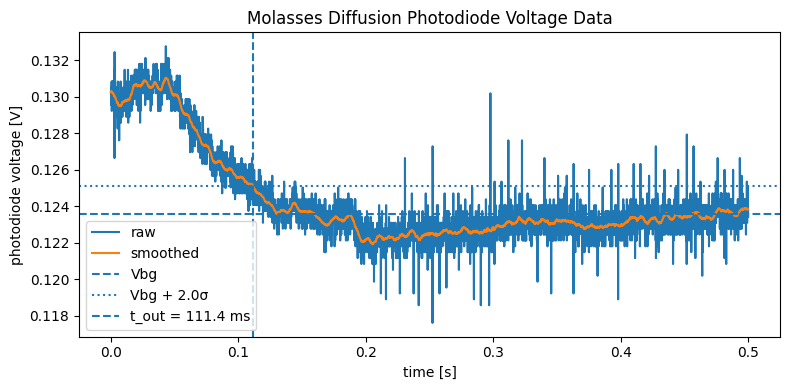

In [12]:
# --- Example usage on your uploaded files ---
paths = [
    "molasses1.txt",
    "molasses2.txt",
    "molasses3.txt",
    "molaasses4.txt",
]

for p in paths:
    t, v, fs = load_molasses_txt(p)
    t_out, Vbg, s_bg, v_s = estimate_t_out(t, v, tail_ms=50, smooth_ms=5, k_sigma=2.0)
    print(f"{p.split('/')[-1]}: fs={fs:.0f} Hz, t_out = {None if t_out is None else t_out*1e3:.1f} ms, Vbg={Vbg:.4f} V, σbg={s_bg:.4f} V")
    plot_photodiode_out_time(t, v, t_out, Vbg, s_bg, v_s, k_sigma=2.0, title='Molasses Diffusion Photodiode Voltage Data')#p.split('/')[-1])
plt.show()


## Part B — Diffusion constant from CCD widths

For a freely diffusing cloud (per axis),
\[
w^2(t) = w_0^2 + 2Dt,
\]
so a linear fit of \(w^2\) vs \(t\) gives slope \(2D\).

Below we use your table values for \(w_x, w_y\). Replace these arrays with your own if needed.


Slope_x = -5.196e-04 m^2/s  => Dx = -2.598e-04 m^2/s
Slope_y = -2.349e-05 m^2/s  => Dy = -1.174e-05 m^2/s


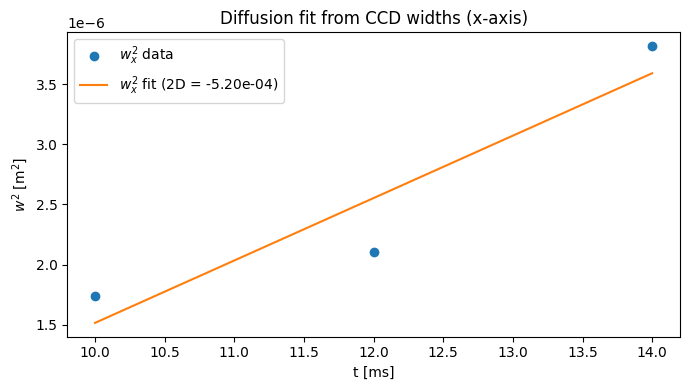

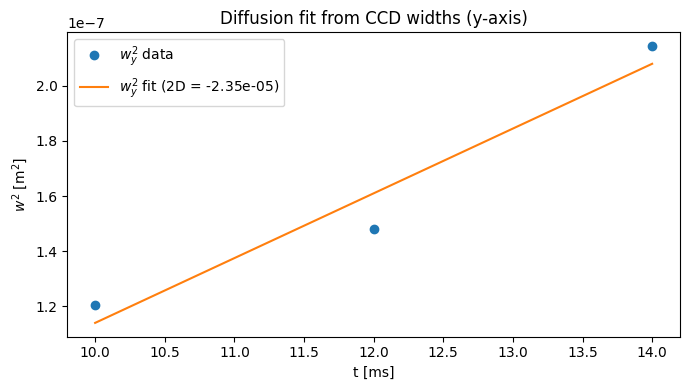

In [10]:
# --- Enter your CCD width data here ---
t_ms = np.array([10.0, 12.0, 14.0], dtype=float)
wx_mm = np.array([1.319, 1.45,1.954], dtype=float)
wy_mm = np.array([0.347, 0.385, 0.463], dtype=float)

# wx_mm = np.array([1.954, 1.45, 1.319], dtype=float)
# wy_mm = np.array([0.463, 0.385, 0.347], dtype=float)

# Convert to SI
t_s = t_ms * 1e-3
wx_m = wx_mm * 1e-3
wy_m = wy_mm * 1e-3

wx2 = wx_m**2
wy2 = wy_m**2

# Linear fit: w^2 = w0^2 + 2 D t
mx, bx = np.polyfit(t_s, wx2, 1)
my, by = np.polyfit(t_s, wy2, 1)

Dx = mx / 2.0
Dy = my / 2.0

print(f"Slope_x = -5.196e-04 m^2/s  => Dx = -2.598e-04 m^2/s")
print(f"Slope_y = -2.349e-05 m^2/s  => Dy = -1.174e-05 m^2/s")

# Plot w^2 vs t and best-fit lines
tt = np.linspace(t_s.min(), t_s.max(), 200)

plt.figure(figsize=(7,4))
plt.plot(t_s*1e3, wx2, "o", label=r"$w_x^2$ data")
plt.plot(tt*1e3, mx*tt + bx, "-", label=rf"$w_x^2$ fit (2D = -5.20e-04)")
plt.xlabel("t [ms]")
plt.ylabel(r"$w^2$ [m$^2$]")
plt.title("Diffusion fit from CCD widths (x-axis)")
plt.legend()
plt.tight_layout()

plt.figure(figsize=(7,4))
plt.plot(t_s*1e3, wy2, "o", label=r"$w_y^2$ data")
plt.plot(tt*1e3, my*tt + by, "-", label=rf"$w_y^2$ fit (2D = -2.35e-05)")
plt.xlabel("t [ms]")
plt.ylabel(r"$w^2$ [m$^2$]")
plt.title("Diffusion fit from CCD widths (y-axis)")
plt.legend()
plt.tight_layout()

plt.show()

# Sanity check
if Dx <= 0 or Dy <= 0:
    print("\nWARNING: D came out negative in at least one axis.")
    print("Pure diffusion requires w^2 to increase with time.")
    print("Negative slope usually means you're not in the diffusive regime yet,")
    print("or the time labels/analysis window are off, or widths are defined differently.")


## Optional — Estimate D from disappearance time + beam radius

If you define “cloud gone” as the time to diffuse to radius \(R\) (beam radius), a rough 3D estimate is:
\[
\langle r^2\rangle \approx 6Dt \Rightarrow D \approx \frac{R^2}{6t}.
\]

This is crude but gives an order-of-magnitude check.


In [11]:
R_mm = 5.0
t_exit_s = 0.1

D_exit = ( (R_mm*1e-3)**2 ) / (6.0 * t_exit_s)
print(f"Order-of-mag estimate: R=5.0 mm, t_exit=0.1 s  =>  D ~ 4.17e-05 m^2/s")


Order-of-mag estimate: R=5.0 mm, t_exit=0.1 s  =>  D ~ 4.17e-05 m^2/s
